# Week 3: Day 4 AM // Practical Statistics: Inferential

## Single-Sample, One-Sided Tests
Our students have completed their school year, and been asked to rate their statistics class on a scale between -5 (terrible) and 5 (fantastic). The statistics class is taught online to tens of thousands of students, so to assess its success, we'll take a random sample of 50 ratings.

Run the following code to draw 50 samples.

Min:-5
Max:5
Mean:0.84


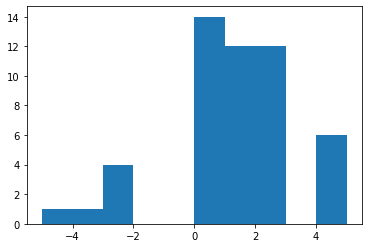

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(123)
lo = np.random.randint(-5, -1, 6)
mid = np.random.randint(0, 3, 38)
hi = np.random.randint(4, 6, 6)
sample = np.append(lo,np.append(mid, hi))
print("Min:" + str(sample.min()))
print("Max:" + str(sample.max()))
print("Mean:" + str(sample.mean()))

plt.hist(sample)
plt.show()

A question we might immediately ask is: "how do students tend to like the class"? In this case, possible ratings were between -5 and 5, with a "neutral" score of 0. In other words, if our average score is above zero, then students tend to enjoy the course. 

In the sample above, the mean score is above 0 (in other words, people liked the class in this data). If you had actually run this course and saw this data, it might lead you to believe that the overall mean rating for this class (i.e., not just the sample) is likely to be positive. 

There is an important point to be made, though: this is just a sample, and you want to make a statement not just about your sample but the whole population from which it came. In other words, you want to know how the class was received overall, but you only have access to a limited set of data. This often the case when analyzing data. 

So, how can you test your belief that your positive looking *sample* reflects the fact that the course does tend to get good evaluations, that your *population* mean (not just your sample mean) is positive?

We start by defining two hypotheses:

* The *null* hypothesis (**H<sub>0</sub>**) is that the population mean for all of the ratings is *not* higher than 0, and the fact that our sample mean is higher than this is due to random chance in our sample selection. 
* The *alternative* hypothesis (**H<sub>1</sub>**) is that the population mean is actually higher than 0, and the fact that our sample mean is higher than this means that our sample correctly detected this trend. 

You can write these as mutually exclusive expressions like this:

$$
\begin{equation}H_{0}: \mu \le 0 \\ H_{1}: \mu > 0 \end{equation}
$$

So how do we test these hypotheses? Because they are mutually exclusive, if we can show the null is probably not true, then we are safe to reject it and conclude that people really do like our online course. But how do we do that?

Well, if the *null* hypothesis is true, the sampling distribution for ratings with a sample size of 50 will be a normal distribution with a mean of 0. Run the following code to visualize this, with the mean of 0 shown as a yellow dashed line.

*(The code just generates a normal distribution with a mean of 0 and a standard deviation that makes it approximate a sampling distribution of 50 random means between -5 and 5 - don't worry too much about the actual values, it's just to illustrate the key points!)*

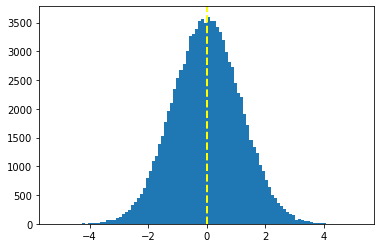

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

pop = np.random.normal(0, 1.15, 100000)
plt.hist(pop, bins=100)
plt.axvline(pop.mean(), color='yellow', linestyle='dashed', linewidth=2)
plt.show()

This illustrates all the *sample* results you could get if the null hypothesis was true (that is, the rating population mean is actually 0). Note that if the null hypothesis is true, it's still *possible* to get a sample with a mean ranging from just over -5 to just under 5. The question is how *probable* is it to get a sample with a mean as high we did for our 50-rating sample under the null hypothesis? And how improbable would it *need* to be for us to conclude that the null is, in fact, a poor explanation for our data? 

Well, we measure distance from the mean in standard deviations, so we need to find out how many standard deviations above the null-hypothesized population mean of 0 our sample mean is, and measure the area under the distribution curve from this point on - that will give us the probability of observing a mean that is *at least* as high as our sample mean. We call the number of standard deviations above the mean where our sample mean is found the *test statistic* (or sometimes just *t-statistic*), and we call the area under the curve from this point (representing the probability of observing a sample mean this high or greater) the *p-value*.

So the p-value tells us how probable our sample mean is when the null is true, but we need to set a threshold under which we consider this to be too improbable to be explained by random chance alone. We call this threshold our *critical value*, and we usually indicate it using the Greek letter alpha (**&alpha;**). You can use any value you think is appropriate for **&alpha;** - commonly a value of 0.05 (5%) is used, but there's nothing special about this value.

We calculate the t-statistic by performing a statistical test. Technically, when the standard deviation of the population is known, we call it a *z-test* (because a *normal* distribution is often called a *z-distribution* and we measure variance from the mean in multiples of standard deviation known as *z-scores*). When the standard deviation of the population is not known, the test is referred to as a *t-test* and based on an adjusted version of a normal distribution called a *student's t distribution*, in which the distribution is "flattened" to allow for more sample variation depending on the sample size. Generally, with a sample size of 30 or more, a t-test is approximately equivalent to a z-test.

Specifically, in this case we're performing a *single sample* test (we're comparing the mean from a single sample of ratings against the hypothesized population mean), and it's a *one-tailed* test (we're checking to see if the sample mean is *greater than* the null-hypothesized population mean - in other words, in the *right* tail of the distribution).

The general formula for one-tailed, single-sample t-test is:

$$
\begin{equation}t = \frac{\bar{x} - \mu}{s \div \sqrt{n}} \end{equation}
$$

In this formula, **x&#772;** is the sample mean, **&mu;** is the population mean, **s** is the standard deviation, and **n** is the sample size. You can think of the numerator of this equation (the expression at the top of the fraction) as a *signal*, and the denominator (the expression at the bottom of the fraction) as being *noise*. The signal measures the difference between the statistic and the null-hypothesized value, and the noise represents the random variance in the data in the form of standard deviation (or standard error). The t-statistic is the ratio of signal to noise, and measures the number of standard errors between the null-hypothesized value and the observed sample mean. A large value tells you that your "result" or "signal" was much larger than you would typically expect by chance.

Fortunately, most programming languages used for statistical analysis include functions to perform a t-test, so you rarely need to manually calculate the results using the formula.

Run the code below to run a single-sample t-test comparing our sample mean for ratings to a hypothesized population mean of 0, and visualize the resulting t-statistic on the normal distribution for the null hypothesis.


t-statistic:2.773584905660377
p-value:0.003911


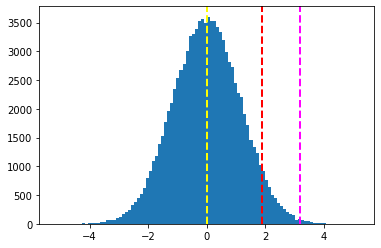

In [3]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# T-Test
t,p = stats.ttest_1samp(sample, 0)
# ttest_1samp is 2-tailed, so half the resulting p-value to get a 1-tailed p-value
p1 = '%f' % (p/2)
print ("t-statistic:" + str(t))
print("p-value:" + str(p1))

# calculate a 90% confidence interval. 10% of the probability is outside this, 5% in each tail
ci = stats.norm.interval(0.90, 0, 1.15)
plt.hist(pop, bins=100)
# show the hypothesized population mean
plt.axvline(pop.mean(), color='yellow', linestyle='dashed', linewidth=2)
# show the right-tail confidence interval threshold - 5% of propbability is under the curve to the right of this.
plt.axvline(ci[1], color='red', linestyle='dashed', linewidth=2)
# show the t-statistic - the p-value is the area under the curve to the right of this
plt.axvline(pop.mean() + t*pop.std(), color='magenta', linestyle='dashed', linewidth=2)
plt.show()

In the plot produced by the code above, the yellow line shows the population mean for the null hypothesis. The area under the curve to the right of the red line represents the critical value of 0.05 (or 5%). The magenta line indicates how much higher the sample mean is compared to the hypothesized population mean. This is calculated as the t-statistic (which is printed above the plot) multiplied by the standard deviation. The area under the curve to the right of this encapsulates the p-value calculated by the test (which is also printed above the plot).

So what should we conclude from these results?

Well, if the p-value is smaller than our critical value of 0.05, that means that under the null hypothesis, the probability of observing a sample mean as high as we did by random chance is low. That's a good sign for us, because it means that our sample is unlikely under the null, and therefore the null is a poor explanation for the data. We can safely *reject* the null hypothesis in favor of the alternative hypothesis - there's enough evidence to suggest that the population mean for our class ratings is greater than 0.

Conversely, if the p-value is greater than the critical value, we *fail to reject the null hypothesis* and conclude that the mean rating is not greater than 0. Note that we never actually *accept* the null hypothesis, we just conclude that there isn't enough evidence to reject it!

## Two-Tailed Tests
The previous test was an example of a one-tailed test in which the p-value represents the area under one tail of the distribution curve. In this case, the area in question is under the right tail because the alternative hypothesis we were trying to show was that the true population mean is *greater than* the mean of the null hypothesis scenario.

Suppose we restated our hypotheses like this:
* The *null* hypothesis (**H<sub>0</sub>**) is that the population mean for all of the ratings is 0, and the fact that our sample mean is higher or lower than this can be explained by random chance in our sample selection.
* The *alternative* hypothesis (**H<sub>1</sub>**) is that the population mean is not equal to 0.

We can write these as mutually exclusive expressions like this:

$$
\begin{equation}H_{0}: \mu = 0 \\ H_{1}: \mu \neq 0 \end{equation}
$$

Why would we do this? Well, in the test we performed earlier, we could only reject the null hypothesis if we had really *positive* ratings, but what if our sample data looked really *negative*? It would be a mistake to turn around and run a one-tailed test the other way, for negative ratings. Instead, we conduct a test designed for such a question: a two-tailed test.

In a two-tailed test, we are willing to reject the null hypothesis if the result is significantly *greater* or *lower* than the null hypothesis. Our critical value (5%) is therefore split in two: the top 2.5% of the curve and the bottom 2.5% of the curve. As long as our test statistic is in that region, we are in the extreme 5% of values (p < .05) and we reject the null hypothesis. In other words, our p-value now needs to be below .025, but it can be in either tail of the distribution. For convenience, we usually "double" the p-value in a two-tailed test so that we don't have to remember this rule and still compare against .05 (this is known as a "two-tailed p-value"). In fact, it is assumed this has been done in all statistical analyses unless stated otherwise. 

The following code shows the results of a two-tailed, single sample test of our class ratings. Note that the ***ttest_1samp*** function in the ***stats*** library returns a 2-tailed p-value by default (which is why we halved it in the previous example).


t-statistic:2.773584905660377
p-value:0.007822


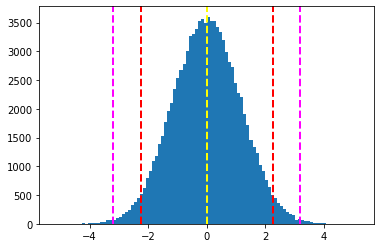

In [4]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# T-Test
t,p = stats.ttest_1samp(sample, 0)
print ("t-statistic:" + str(t))
# ttest_1samp is 2-tailed
print("p-value:" + '%f' % p)
# calculate a 95% confidence interval. 50% of the probability is outside this, 2.5% in each tail
ci = stats.norm.interval(0.95, 0, 1.15)
plt.hist(pop, bins=100)
# show the hypothesized population mean
plt.axvline(pop.mean(), color='yellow', linestyle='dashed', linewidth=2)
# show the confidence interval thresholds - 5% of propbability is under the curve outside these.
plt.axvline(ci[0], color='red', linestyle='dashed', linewidth=2)
plt.axvline(ci[1], color='red', linestyle='dashed', linewidth=2)
# show the t-statistic thresholds - the p-value is the area under the curve outside these
plt.axvline(pop.mean() - t*pop.std(), color='magenta', linestyle='dashed', linewidth=2)
plt.axvline(pop.mean() + t*pop.std(), color='magenta', linestyle='dashed', linewidth=2)
plt.show()

Here we see that our 2-tailed p-value was clearly less than 0.05; so We reject the null hypothesis.

You may note that doubling the p-value in a two-tailed test makes it harder to reject the null. This is true; we require more evidence because we are asking a more complicated question. 



## Two-Sample Tests
In both of the previous examples, we compared a statistic from a single data sample to a null-hypothesized population parameter. Sometimes you might want to compare two samples against one another.

For example, let's suppose that some of the students who took the statistics course had previously studied mathematics, while other students had no previous math experience. You might hypothesize that the grades of students who had previously studied math are significantly higher than the grades of students who had not.

* The *null* hypothesis (**H<sub>0</sub>**) is that the population mean grade for students with previous math studies is not greater than the population mean grade for students without any math experience, and the fact that our sample mean for math students is higher than our sample mean for non-math students can be explained by random chance in our sample selection.
* The *alternative* hypothesis (**H<sub>1</sub>**) is that the population mean grade for students with previous math studies is greater than the population mean grade for students without any math experience.

We can write these as mutually exclusive expressions like this:

$$
\begin{equation}H_{0}: \mu_{1} \le \mu_{2} \\ H_{1}: \mu_{1} > \mu_{2} \end{equation}
$$

This is a one-sided test that compares two samples. To perform this test, we'll take two samples. One sample contains 100 grades for students who have previously studied math, and the other sample contains 100 grades for students with no math experience.

We won't go into the test-statistic formula here, but it essentially the same as the one above, adapted to include information from both samples. We can easily test this in most software packages using the command for an "independent samples" t-test:


non-math sample mean:66.04066361023553
math sample mean:66.52069665713476
t-statistic:2.140008413392296
p-value:0.016789


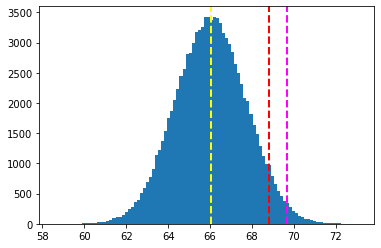

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

np.random.seed(123)
nonMath = np.random.normal(66.0, 1.5, 100)
math = np.random.normal(66.55, 1.5, 100)
print("non-math sample mean:" + str(nonMath.mean()))
print("math sample mean:" + str(math.mean()))

# Independent T-Test
t,p = stats.ttest_ind(math, nonMath)
# ttest_ind is 2-tailed, so half the resulting p-value to get a 1-tailed p-value
p1 = '%f' % (p/2)
print("t-statistic:" + str(t))
print("p-value:" + str(p1))

pop = np.random.normal(nonMath.mean(), nonMath.std(), 100000)
# calculate a 90% confidence interval. 10% of the probability is outside this, 5% in each tail
ci = stats.norm.interval(0.90, nonMath.mean(), nonMath.std())
plt.hist(pop, bins=100)
# show the hypothesized population mean
plt.axvline(pop.mean(), color='yellow', linestyle='dashed', linewidth=2)
# show the right-tail confidence interval threshold - 5% of propbability is under the curve to the right of this.
plt.axvline(ci[1], color='red', linestyle='dashed', linewidth=2)
# show the t-statistic - the p-value is the area under the curve to the right of this
plt.axvline(pop.mean() + t*pop.std(), color='magenta', linestyle='dashed', linewidth=2)
plt.show()

You can interpret the results of this test the same way as for the previous single-sample, one-tailed test. If the p-value (the area under the curve to the right of the magenta line) is smaller than our critical value (**&alpha;**) of 0.05 (the area under the curve to the right of the red line), then the difference can't be explained by chance alone; so we can reject the null hypothesis and conclude that students with previous math experience perform better on average than students without.

Alternatively, you could always compare two groups and *not* specify a direction (i.e., two-tailed). If you did this, as above, you could simply double the p-value (now .001), and you would see you could still reject the null hypothesis.

## Paired Tests
In the two-sample test we conduced previously, the samples were independent; in other words there was no relatioship between the observations in the first sample and the observations in the second sample. Sometimes you might want to compare statistical differences between related observations before and after some change that you believe might influence the data.

For example, suppose our students took a mid-term exam, and later took and end-of-term exam. You might hypothesise that the students will improve their grades in the end-of-term exam, after they've undertaken additional study. We could test for a general improvement on average across all students with a two-sample independent test, but a more appropriate test would be to compare the two test scores for each individual student.

To accomplish this, we need to create two samples; one for scores in the mid-term, exam, the other for scores in the end-of-term exam. Then we need to compare the samples in such a way that each pair of observations for the same student are compared to one another. 

This is known as a paired-samples t-test or a dependent-samples t-test. Technically, it tests whether the *changes* tend to be in the positive or negative direction.

t-statistic:2.3406857739212583
p-value:0.010627


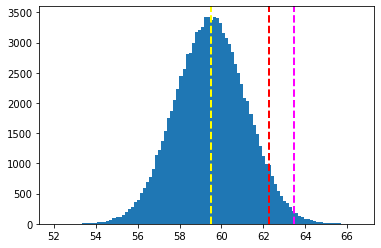

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

np.random.seed(123)
midTerm = np.random.normal(59.45, 1.5, 100)
endTerm = np.random.normal(60.05, 1.5, 100)

# Paired (related) test
t,p = stats.ttest_rel(endTerm, midTerm)
# ttest_rel is 2-tailed, so half the resulting p-value to get a 1-tailed p-value
p1 = '%f' % (p/2)
print("t-statistic:" + str(t))
print("p-value:" + str(p1))

pop = np.random.normal(midTerm.mean(), midTerm.std(), 100000)
# calculate a 90% confidence interval. 10% of the probability is outside this, 5% in each tail
ci = stats.norm.interval(0.90, midTerm.mean(), midTerm.std())
plt.hist(pop, bins=100)
# show the hypothesized population mean
plt.axvline(pop.mean(), color='yellow', linestyle='dashed', linewidth=2)
# show the right-tail confidence interval threshold - 5% of propbability is under the curve to the right of this.
plt.axvline(ci[1], color='red', linestyle='dashed', linewidth=2)
# show the t-statistic - the p-value is the area under the curve to the right of this
plt.axvline(pop.mean() + t*pop.std(), color='magenta', linestyle='dashed', linewidth=2)
plt.show()

In our sample, we see that scores did in fact improve, so we can we reject the null hypothesis.